In [1]:
 ! pip install xgboost shap pandas scikit-learn ipywidgets matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

In [3]:
#Download csv files
SF_Tree1 = pd.read_csv('LDP_Sap_Flow_Tree1.csv')
SF_Tree2 = pd.read_csv('LDP_Sap_Flow_Tree2.csv')
SF_Total = pd.read_csv('LDP_Total_LDP_Sap_Flow.csv')
VWC = pd.read_csv('LDP_Met_VWC.csv')
AE = pd.read_csv('LDP_Met_Available_Energy.csv')
P = pd.read_csv('LDP_Met_Precipitation.csv')
VPD = pd.read_csv('LDP_Met_VPD.csv')
RH = pd.read_csv('LDP_Met_RH.csv')
AT = pd.read_csv('LDP_Met_AT.csv')

In [4]:
# #Convert the string csv format to a pandas datetime DataFrame
SF_Tree1['DateTime'] = pd.to_datetime(SF_Tree1['DateTime'])
SF_Tree2['DateTime'] = pd.to_datetime(SF_Tree2['DateTime'])
SF_Total['DateTime'] = pd.to_datetime(SF_Total['DateTime'])
VWC['DateTime'] = pd.to_datetime(VWC['DateTime'])
AE['DateTime'] = pd.to_datetime(AE['DateTime'])
P['DateTime'] = pd.to_datetime(P['DateTime'])
VPD['DateTime'] = pd.to_datetime(VPD['DateTime'])
RH['DateTime'] = pd.to_datetime(RH['DateTime'])
AT['DateTime'] = pd.to_datetime(AT['DateTime'])

# #Make the index for the rows be the DateTime column 
LDP_SF_Tree1 = SF_Tree1.set_index('DateTime', inplace=True)
LDP_SF_Tree2 = SF_Tree2.set_index('DateTime', inplace=True)
LDP_Total_SF = SF_Total.set_index('DateTime', inplace=True)
LDP_VWC = VWC.set_index('DateTime', inplace=True)
LDP_AE = AE.set_index('DateTime', inplace=True)
LDP_P = P.set_index('DateTime', inplace=True)
LDP_VPD = VPD.set_index('DateTime', inplace=True)
LDP_RH = RH.set_index('DateTime', inplace=True)
LDP_AT = AT.set_index('DateTime', inplace=True)

In [5]:
#Fill in datetime gaps 
complete_date_rng = pd.date_range(start='05/25/2023', end='12/31/2023', freq='H')[:-1] #'mm/dd/yyyy

## Identified Missing Dates from dataset ##
missing_dates = complete_date_rng.difference(SF_Tree1.index)

## Reset index with all datetimes and gaps filled with NaN
SF_LDP1 = SF_Tree1.reindex(complete_date_rng)
SF_LDP1.index.name = 'DateTime' # name the new datetime column
LDP1_missing_dates = SF_Tree1.reset_index()

In [6]:
concat_data = pd.concat([VWC, VPD, AT, P, AE, RH, SF_Total['2023-05-25 18:00:00':'2023-12-31 23:00:00']], axis=1)
concat_data.apply(pd.to_numeric)

concat_data1 = pd.concat([VWC, VPD, AT, P, AE, RH, SF_Tree1['2023-05-25 18:00:00':'2023-12-31 23:00:00']], axis=1)
concat_data1.apply(pd.to_numeric)

concat_data2 = pd.concat([VWC, VPD, AT, P, AE, RH, SF_Tree2['2023-05-25 18:00:00':'2023-12-31 23:00:00']], axis=1)
concat_data2.apply(pd.to_numeric)

,Volumetric Water Content (cm3/cm3),Vapor Pressure Deficit (kPa),AirTemp_C,Precipitation_mm,Available Energy (W/m2),Relative_Humidity_%,LDP Total Sap Flow L/hr
DateTime,,,,,,,
2023-05-25 18:00:00,0.249,0.884738,15.5,269.3,469.52,49.76,1.456943
2023-05-25 19:00:00,0.249,0.830308,14.8,269.3,310.35,50.68,1.403103
2023-05-25 20:00:00,0.248,0.774084,14.3,269.3,167.30,52.51,1.188976
2023-05-25 21:00:00,0.248,0.650155,12.4,269.3,58.77,54.85,0.795763
2023-05-25 22:00:00,0.247,0.657352,12.1,269.3,54.89,53.44,0.422618
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0.336,0.141627,0.8,575.9,68.39,78.12,0.237509
2023-12-31 20:00:00,0.336,0.221652,1.3,575.9,67.62,66.97,0.222761
2023-12-31 21:00:00,0.336,0.214182,1.1,575.9,65.66,67.62,0.221043


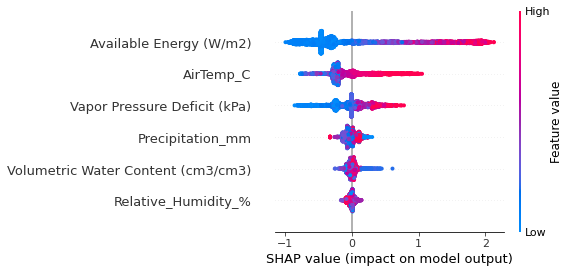

<Figure size 432x288 with 0 Axes>

In [12]:
#SHAP model Total SF
# Define sap flow as the target variable (y) and the remaining independent variables (X)
X = concat_data.drop("Total Sap Flow L/hr", axis=1)
y = concat_data["Total Sap Flow L/hr"]
 
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)
 
#Create an XGBRegressor model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
 
#Save the XGBoost model in binary format
model.save_model('model.json')
 
#Load the model from the saved binary file
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('model.json')
 
#Load and define the SHAP Explainer
explainer = shap.Explainer(loaded_model)
shap_values = explainer(X_test)
 
#Start the SHAP JavaScript library
shap.summary_plot(shap_values, X_test)
plt.savefig("SHAP_TSF.jpg", dpi=300)
plt.show()

AE/SF: high values in pink are closer to +1 and +2 implying it has the largest effect on the SF
AT/SF: Similar to AE 
VPD/SF: has some high pink values above 0 but not many and more dots are negative and blue meaning low
P/SF: Most of its values sit on 0 and any pink is close to 0
VWC/SF: Similar to P
RH/SF: High pink values are near 0 or negative, so less of a factor?

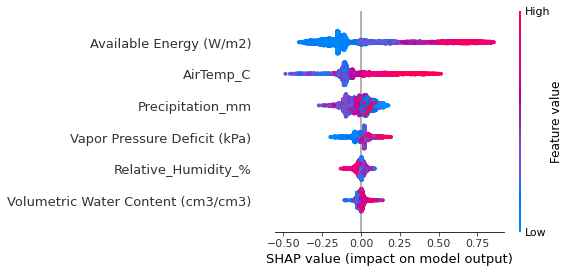

In [13]:
#SHAP model SF1
# Define sap flow as the target variable (y) and the remaining independent variables (X)
X = concat_data1.drop("LDP1 Total Sap Flow L/hr", axis=1)
y = concat_data1["LDP1 Total Sap Flow L/hr"]
 
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)
 
#Create an XGBRegressor model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
 
#Save the XGBoost model in binary format
model.save_model('model.json')
 
#Load the model from the saved binary file
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('model.json')
 
#Load and define the SHAP Explainer
explainer = shap.Explainer(loaded_model)
shap_values = explainer(X_test)
 
#Start the SHAP JavaScript library
shap.summary_plot(shap_values, X_test)

AE/SF: high values in pink are closer to +0.75 implying it has the largest effect on the SF
AT/SF: Similar to AE 
VPD/SF: has some high pink values above 0 but not many and more dots are negative and blue meaning low
P/SF: Most of its values sit on 0 or are clustered in the negatives
VWC/SF: most values are clustered around 0 or in the negative especially the high values
RH/SF: High pink values are near 0 or negative, so less of a factor?

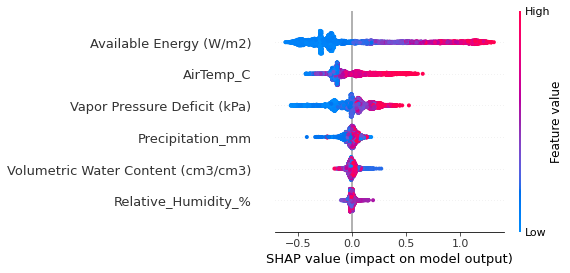

In [14]:
#SHAP model SF2
# Define sap flow as the target variable (y) and the remaining independent variables (X)
X = concat_data2.drop("LDP Total Sap Flow L/hr", axis=1)
y = concat_data2["LDP Total Sap Flow L/hr"]
 
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)
 
#Create an XGBRegressor model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
 
#Save the XGBoost model in binary format
model.save_model('model.json')
 
#Load the model from the saved binary file
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('model.json')
 
#Load and define the SHAP Explainer
explainer = shap.Explainer(loaded_model)
shap_values = explainer(X_test)
 
#Start the SHAP JavaScript library
shap.summary_plot(shap_values, X_test)

AE/SF: high values in pink are closer to +0.75 implying it has the largest effect on the SF
AT/SF: Similar to AE 
VPD/SF: has some high pink values above 0 but not many and more dots are negative and blue meaning low
P/SF: Most of its values sit on 0 or are clustered in the negatives
VWC/SF: most values are clustered around 0 or in the negative especially the high values
RH/SF: High pink values are near 0 or negative, so less of a factor?